In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.009189945184785569 0.03215941558734649; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863965 -0.10696223889695361], [-0.0037362031674817945 0.011184638740456908 … -0.07094318488635357 -0.05032349162445888; 0.01979088919057409 0.030620168627788782 … 0.03078518538867422 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.13735992748512493 0.03213684839745743; 0.042094688716242876 -0.10110240825174423 … -0.0663617447355249 -0.08508079724902799], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

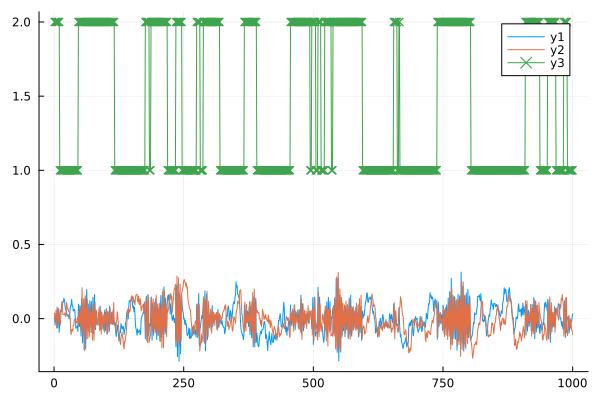

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

#Q = Matrix(0.5 * I(d))

#x0 = [0.0; 0.0]
#P0 = Matrix(0.5 * I(d))

x0 = model.B[1].state_model.x0
P0 = model.B[1].state_model.P0

# set up the observation parameters
#C = randn(p, d)
R = Matrix(0.5 * I(p))

C = model.B[1].obs_model.C
#R = model.B[1].obs_model.R

# B = [StateSpaceDynamics.LinearDynamicalSystem(
#     StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
#     StateSpaceDynamics.GaussianObservationModel(C, R),
#     d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

B = [StateSpaceDynamics.LinearDynamicalSystem(
   StateSpaceDynamics.GaussianStateModel(model.B[i].state_model.A, model.B[i].state_model.Q, x0, P0),
   StateSpaceDynamics.GaussianObservationModel(C, R),
   d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.8638325554843976; 0.863

In [6]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [7]:
modeli.A

2×2 Matrix{Float64}:
 0.9  0.1
 0.2  0.8

In [8]:
K = modeli.K
T_step = size(y, 2)
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(model.B[k], T_step) for k in 1:K]
ml = zeros(10)

for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)   
end

In [9]:
ml

10-element Vector{Float64}:
 73.43739156835943
 25.816369923128036
 24.97115873487553
 24.344559662813595
 24.21620821169836
 24.195019567326653
 24.19210172094472
 24.191868475849446
 24.19191823858614
 24.191955810868308

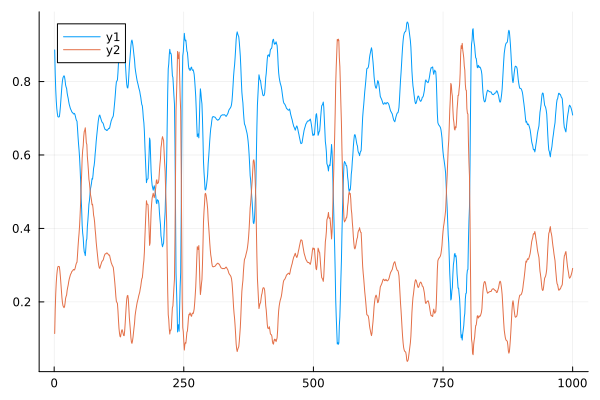

In [10]:
plot(exp.(FB.γ[1,:]))
plot!(exp.(FB.γ[2,:]))

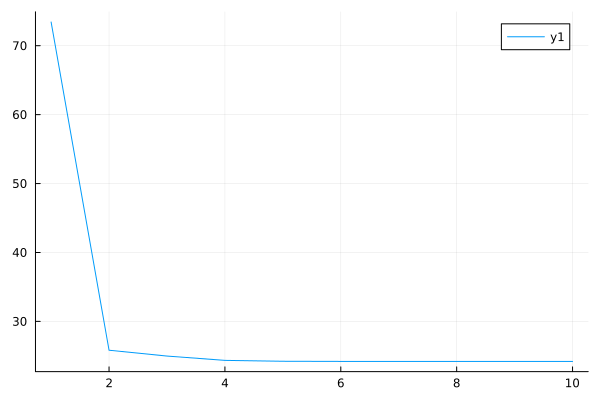

In [11]:
plot(ml)

In [12]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=10)

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:00:04 ( 0.47  s/it)


([24.191955810868308, -4574.34333012426, -4921.545230881285, -5074.637253304585, -5141.562465888813, -5176.286948652754, -5195.021958961525, -5205.385228672995, -5211.2066737752875, -5214.508565120299], [2.1975866954243233, 0.062229619406753534, 0.00986713280258369, 0.003495340400209519, 0.0016267588072220224, 0.0008414027371190426, 0.0004601678851074302, 0.0002595589461937028, 0.00014899505415531884, 8.639561473635709e-5], StateSpaceDynamics.ForwardBackward{Float64}([-3.560225208875812 -5.940929642157215 … -4.921010111862806 -8.21961446667704; -18.05608124665602 -40.24423176872333 … -120.39330736070153 -130.2204231694868], [-3.560225208875812 -9.512398224445507 … -5206.277709396578 -5214.508567236667; -134.5305054395071 -48.29804975096386 … -5326.23235604537 -5340.99172533943], [-5210.94834202784 -5204.996169012271 … -8.23085784008952 0.0; -5214.0076994163255 -5208.055526400751 … -11.290215228574379 0.0], [0.0 0.0 … 0.0 0.0; -134.02963761911633 -41.84500891499829 … -123.01400403727621

In [13]:
param_diff

10-element Vector{Float64}:
 2.1975866954243233
 0.062229619406753534
 0.00986713280258369
 0.003495340400209519
 0.0016267588072220224
 0.0008414027371190426
 0.0004601678851074302
 0.0002595589461937028
 0.00014899505415531884
 8.639561473635709e-5

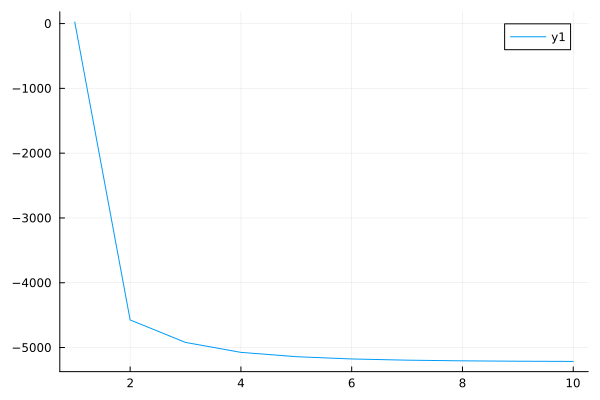

In [14]:
plot(mls)

In [15]:
diff(mls)

9-element Vector{Float64}:
 -4598.535285935129
  -347.2019007570243
  -153.09202242330048
   -66.92521258422767
   -34.72448276394152
   -18.735010308771052
   -10.363269711469911
    -5.821445102292273
    -3.301891345011427

In [16]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [17]:
1 .- eps()

0.9999999999999998

In [18]:
modeli.A

2×2 Matrix{Float64}:
 0.98882    0.0111804
 0.0463932  0.953607

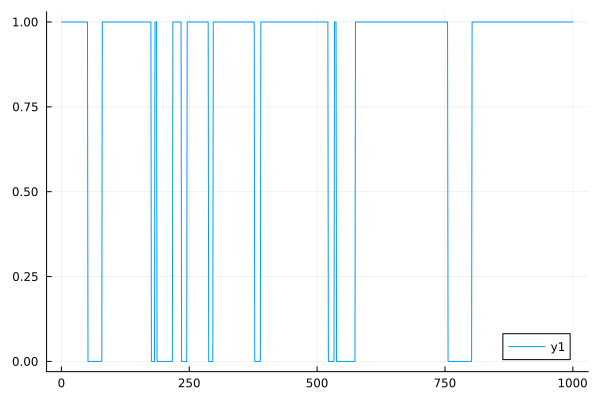

In [19]:
plot(exp.(FB.γ[1,:]))
#plot!(exp.(FB.γ[2,:]))

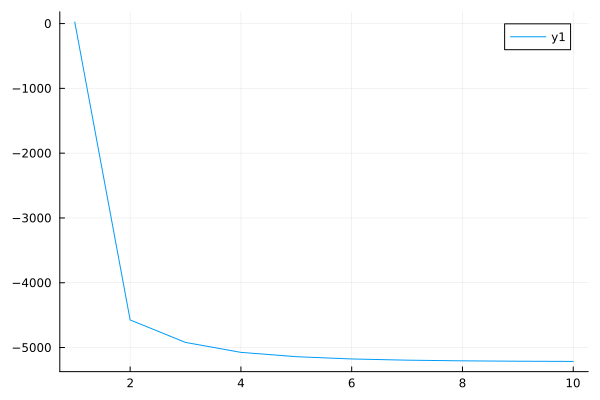

In [20]:
plot(mls)

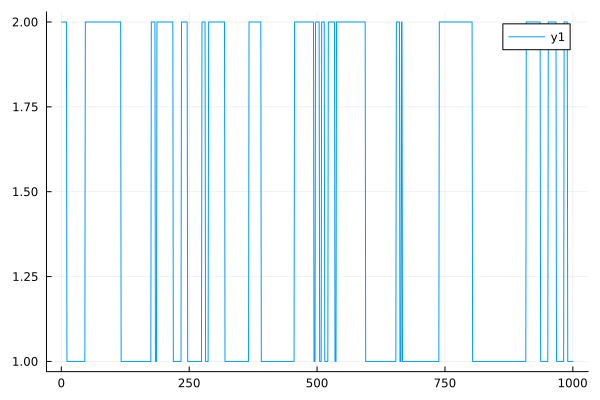

In [21]:
plot(z)

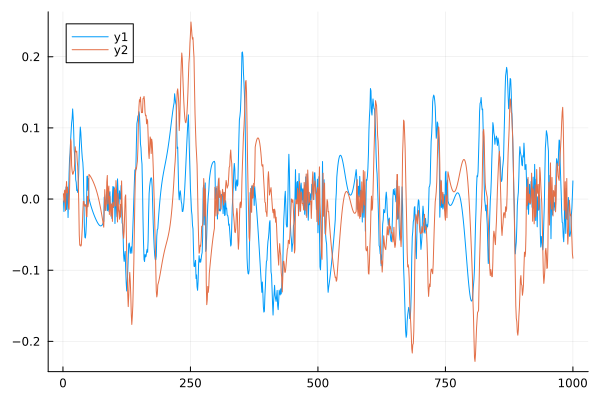

In [22]:
plot(FS[1].x_smooth')

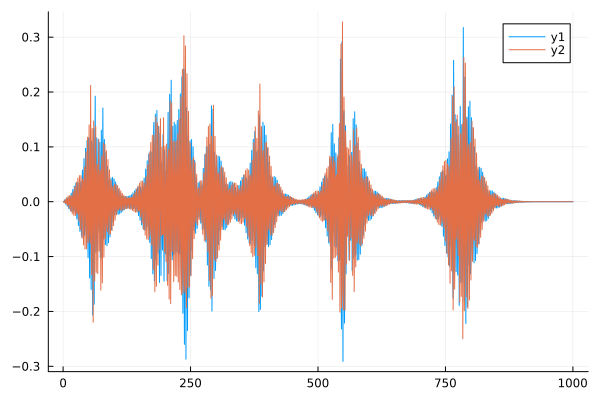

In [23]:
plot(FS[2].x_smooth')


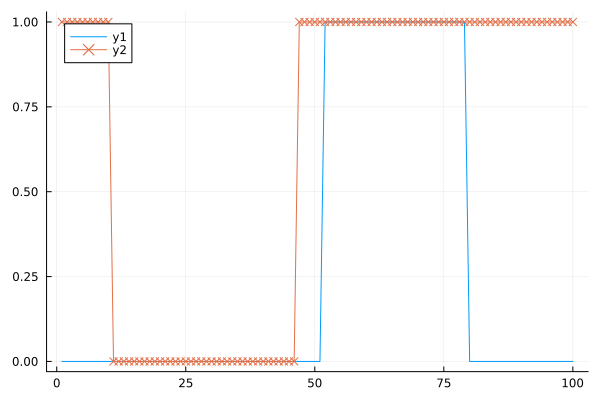

In [24]:
plot(exp.(FB.γ)'[1:100,2])
plot!(z[1:100] .- 1, marker=:x)

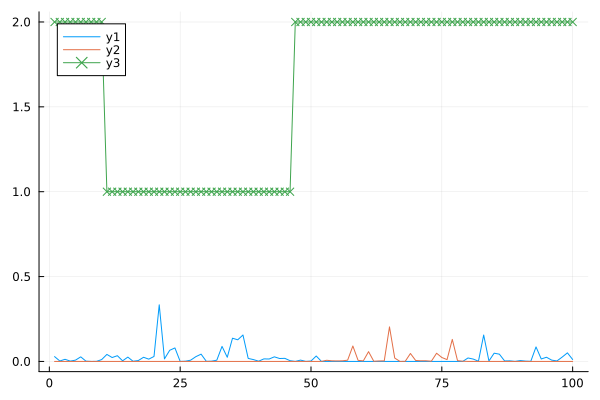

In [25]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

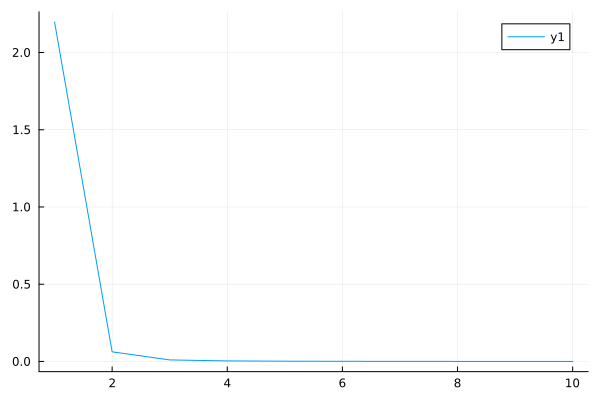

In [26]:
plot(param_diff)